In [3]:
# creating spectrograms from all the files, and saving split labelled versions to disk ready for machine learning
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

import os
import sys
import cPickle as pickle
import numpy as np
import time
import random 

from scipy.ndimage.interpolation import zoom

#from data_helpers import load_annotations

import nolearn
import nolearn.lasagne
import lasagne.layers

from lasagne.layers import InputLayer, DimshuffleLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.nonlinearities import softmax, very_leaky_rectify as vlr
import theano

base = '/media/michael/Seagate/engage/alison_data/golden_set/'
annotation_pkl_dir = base + 'extracted/annotations/'
spec_pkl_dir = base + 'extracted/specs/'
log_dir = base + 'ml_runs/'

Using gpu device 0: GeForce GTX 770 (CNMeM is disabled, cuDNN 5004)
/home/michael/anaconda/lib/python2.7/site-packages/Theano-0.9.0.dev1-py2.7.egg/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [36]:
HWW = 15
SPEC_HEIGHT = 330
LEARN_LOG = False
DO_AUGMENTATION = True
DO_BATCH_NORM = True

In [37]:
# create a class for the spectrograms, from which we can get minbatches of data
class SpecSampler(object):
    
    def _ensure_correct_shape_spec(self, spec):
        if spec.ndim == 2:
            return spec[None, ...]
        else:
            return spec
    
    def __init__(self, specs, labels, hww):       
        self.specs = np.vstack(self._ensure_correct_shape_spec(spec) for spec in specs)
        self.median = np.median(self.specs, 2)
        self.labels = labels
        self.hww = hww
    
    def _ensure_shape(self, X):
        if X.shape[2] < self.hww * 2:
            return np.pad(X, ((0, 0), (0, 0), (0, self.hww * 2 - X.shape[2])), 'constant')
        else:
            return X
    
    def sample(self, num_per_class, seed=None):
        
        tic = time.time()
        num_samples = num_per_class * 2
        channels = self.specs.shape[0]
        height = self.specs.shape[1]
        
        if seed is not None:
            np.random.seed(seed)

        X = np.zeros((num_samples, channels, height, self.hww*2), np.float32)
        y = np.zeros(num_samples) * np.nan
        count = 0
        tic = time.time()
        
        for cls in [0, 1]:
            possible_locs = np.where(self.labels==cls)[0]

            if len(possible_locs) >= num_per_class:
                sampled_locs = np.random.choice(possible_locs, num_per_class, replace=False)

                for loc in sampled_locs:
                    X[count] = self._ensure_shape(
                        self.specs[:, :, (loc-self.hww):(loc+self.hww)])
                    y[count] = cls
                    count += 1

        # remove ones we couldn't get
        to_remove = np.isnan(y)
        return X[~to_remove], y[~to_remove].astype(np.int32)
        
        
#ss = SpecSampler([np.log((0.001+ melspec))[None, :100, :]], {0: bio_zoomed}, 10)

In [38]:
# load data and make list of specsamplers
samplers = []

for fname in os.listdir(spec_pkl_dir):
    
    # load spectrogram and annotations
    spec = pickle.load(open(spec_pkl_dir + fname))[:SPEC_HEIGHT, :]
    annots, wav, sample_rate = pickle.load(
        open(annotation_pkl_dir + fname))
        
    # reshape annotations
    for classname in annots:
        factor = float(spec.shape[1]) / annots[classname].shape[0]
        annots[classname] = zoom(annots[classname], factor)
        
    # create sampler
    if not LEARN_LOG:
        spec = np.log(0.001 + spec)
        spec = spec - np.median(spec, axis=1, keepdims=True)

    spec_stack = [spec]#, np.random.rand(*logspec.shape)]
    ss = SpecSampler(spec_stack, annots['biotic'], HWW)
    ss.fname = fname
    samplers.append(ss)

In [39]:
class MyBatch(nolearn.lasagne.BatchIterator):
    def __iter__(self):
        bs = self.batch_size
        for sampler in self.X:
            xb, yb = sampler.sample(bs)
            
            num = xb.shape[0]
        
            # augmentation
            if DO_AUGMENTATION:
                xb *= (1.0 + np.random.randn(num, 1, 1, 1) * 0.1)
                xb += np.random.randn(num, 1, 1, 1) * 0.05

            if LEARN_LOG:
                # get medians
                meds = np.tile(sampler.median, (num, 1, 1))
                meds = np.tile(meds[:, :, :, None], (1, 1, 1, HWW*2))

                yield {'input': xb.astype(np.float32),
                      'input_med': meds.astype(np.float32)}, yb
            else:
                yield xb.astype(np.float32), yb

            
class MyBatchTest(nolearn.lasagne.BatchIterator):
    def __iter__(self):
        bs = self.batch_size
        for sampler in self.X:
            xb, yb = sampler.sample(bs, seed=10)

            if LEARN_LOG:
                meds = np.tile(sampler.median, (xb.shape[0], 1, 1))
                meds = np.tile(meds[:, :, :, None], (1, 1, 1, HWW*2))
                yield {'input': xb.astype(np.float32),
                      'input_med': meds.astype(np.float32)}, yb
            else:
                yield xb.astype(np.float32), yb
                

mb = MyBatch(20)
mb.X = samplers

for count, (xx, yy) in enumerate(mb):
    if LEARN_LOG:
        print xx['input'].max(), xx['input_med'].shape, yy.sum()
    else:
        print xx.shape, yy.sum(), xx.sum()
    break

(40, 1, 330, 30) 20 -23309.3


In [40]:
import yaml             
# splits 
splits = yaml.load(open(base + 'splits/folds.yaml'))
train = splits[0] + splits[1]
test = splits[2]
                
class MyTrainSplit(nolearn.lasagne.TrainSplit):
    # custom data split
    def __call__(self, data, Yb, net):
        train_samplers = [xx for xx in samplers if xx.fname in train]
        test_samplers = [xx for xx in samplers if xx.fname in test]
        print len(train_samplers), len(test_samplers)
        return train_samplers, test_samplers, None, None

In [ ]:
# from lasagne.nonlinearities import elu as vlr
from lasagne.nonlinearities import softmax, very_leaky_rectify as vlr
from lasagne.layers import batch_norm, ElemwiseSumLayer, ExpressionLayer, DimshuffleLayer
from helpers import Log1Plus, ForgetSizeLayer
import theano.tensor as T

if not DO_BATCH_NORM:
    batch_norm = lambda x: x
net = {}

# main input layer, then logged
net['input'] = InputLayer((None, len(spec_stack), SPEC_HEIGHT, HWW*2), name='input')

if LEARN_LOG:
    off = lasagne.init.Constant(0.5)
    mult = lasagne.init.Constant(1.0)

    net['input_logged'] = Log1Plus(net['input'], off, mult)

    # logging the median and multiplying by -1
    net['input_med'] = InputLayer((None, len(spec_stack), SPEC_HEIGHT, HWW*2), name='input_med')
    net['med_logged'] = Log1Plus(net['input_med'], off=net['input_logged'].off, mult=net['input_logged'].mult)
    net['med_logged'] = ExpressionLayer(net['med_logged'], lambda X: -X)

    # summing the logged input with the negative logged median
    net['input'] = ElemwiseSumLayer((net['input_logged'], net['med_logged']))

net['conv1_1'] = batch_norm(
    ConvLayer(net['input'], 80, (spec.shape[0] - 5, 6), nonlinearity=vlr))
net['pool1'] = PoolLayer(net['conv1_1'], pool_size=(2, 2), stride=(2, 2), mode='average_inc_pad')
net['pool1'] = DropoutLayer(net['pool1'], p=0.5)
net['conv1_2'] = batch_norm(ConvLayer(net['pool1'], 80, (1, 3), nonlinearity=vlr))
# net['pool2'] = PoolLayer(net['conv1_2'], pool_size=(1, 2), stride=(1, 1))
net['pool2'] = DropoutLayer(net['conv1_2'], p=0.5)

net['fc6'] = batch_norm(DenseLayer(net['pool2'], num_units=512, nonlinearity=vlr))
net['fc6'] = DropoutLayer(net['fc6'], p=0.5)
net['fc7'] = batch_norm(DenseLayer(net['fc6'], num_units=512, nonlinearity=vlr))
net['fc7'] = DropoutLayer(net['fc7'], p=0.5)
net['fc8'] = DenseLayer(net['fc7'], num_units=2, nonlinearity=None)
net['prob'] = NonlinearityLayer(net['fc8'], softmax)

net = nolearn.lasagne.NeuralNet(
    layers=net['prob'],
    max_epochs=500,
    update=lasagne.updates.adam,
    update_learning_rate=0.0001,
#     update_momentum=0.975,
    verbose=1,
    batch_iterator_train=MyBatch(128),
    batch_iterator_test=MyBatchTest(128),
    train_split=MyTrainSplit(None),
    check_input=False
)

In [ ]:
net.fit(samplers, None)

26 14
# Neural Network with 1669538 learnable parameters

## Layer information

  #  name    size
---  ------  --------
  0  input   1x330x30
  1          80x6x25
  2          80x6x25
  3          80x6x25
  4          80x3x12
  5          80x3x12
  6          80x3x10
  7          80x3x10
  8          80x3x10
  9          80x3x10
 10          512
 11          512
 12          512
 13          512
 14          512
 15          512
 16          512
 17          512
 18          2
 19          2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       1.01290       0.99854      1.01437      0.60352  3.89s
      2       0.93801       0.89206      1.05151      0.60714  3.99s
      3       0.88457       0.75184      1.17654      0.63839  3.91s
      4       0.83075       0.91501      0.90791      0.61440  3.94s
      5       0.83149       0.77924      1.06706      0.66518  3.98s
      6       0.79767

In [86]:
print net.layers_['log1plus1'].off.get_value()
print net.layers_['log1plus3'].off.get_value()
print net.layers_['log1plus1'].mult.get_value()
print net.layers_['log1plus3'].mult.get_value()

[ 0.96733618]
[ 0.96733618]
[ 1.03238153]
[ 1.03238153]


<module 'matplotlib.pyplot' from '/home/michael/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

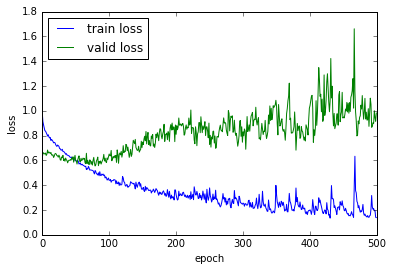

In [93]:
def plot_loss(net):
    train_loss = [row['train_loss'] for row in net.train_history_]
    valid_loss = [row['valid_loss'] for row in net.train_history_]
    plt.plot(train_loss, label='train loss')
    plt.plot(valid_loss, label='valid loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    return plt
plot_loss(net)

In [ ]:
y = [0.197185359589, 0.518698018591, 0.581381482387, 0.664551736791, 0.699983182485]
x = [100, 500, 1000, 2500, 5000]
